## 1. Prepare dataset for pgmpy

In [18]:
import pandas as pd

df = pd.read_csv('C:\\Users\\kathi\\PycharmProjects\\Assignment 4\\auto-mpg.csv')

continuous_vars = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']

for var in continuous_vars:
    median_val = df[var].median()
    df[var] = df[var].apply(lambda x: 'high' if x > median_val else 'low')

print(df.head())

   mpg  cylinders displacement horsepower weight acceleration  model year  \
0  low          8         high       high   high          low          70   
1  low          8         high       high   high          low          70   
2  low          8         high       high   high          low          70   
3  low          8         high       high   high          low          70   
4  low          8         high       high   high          low          70   

   origin                   car name  
0       1  chevrolet chevelle malibu  
1       1          buick skylark 320  
2       1         plymouth satellite  
3       1              amc rebel sst  
4       1                ford torino  


## 2a. Structure Learning with PC Algorithm

First we use the `pgmpy` library to demonstrate the structure learning of Bayesian networks using different variants of the PC algorithm. Each variant is applied to a preprocessed dataset where continuous variables have been discretized.

[PC Algorithm and its variants on pgmpy](https://pgmpy.org/structure_estimator/pc.html#module-pgmpy.estimators.CITests)

### PC Algorithm Variants:
1. **Original (orig)**: Minimal independence tests; results may vary across runs.
2. **Stable**: More tests for consistent results across runs.
3. **Parallel**: Utilizes multiple cores for faster computation without sacrificing consistency.

  0%|          | 0/4 [00:00<?, ?it/s]

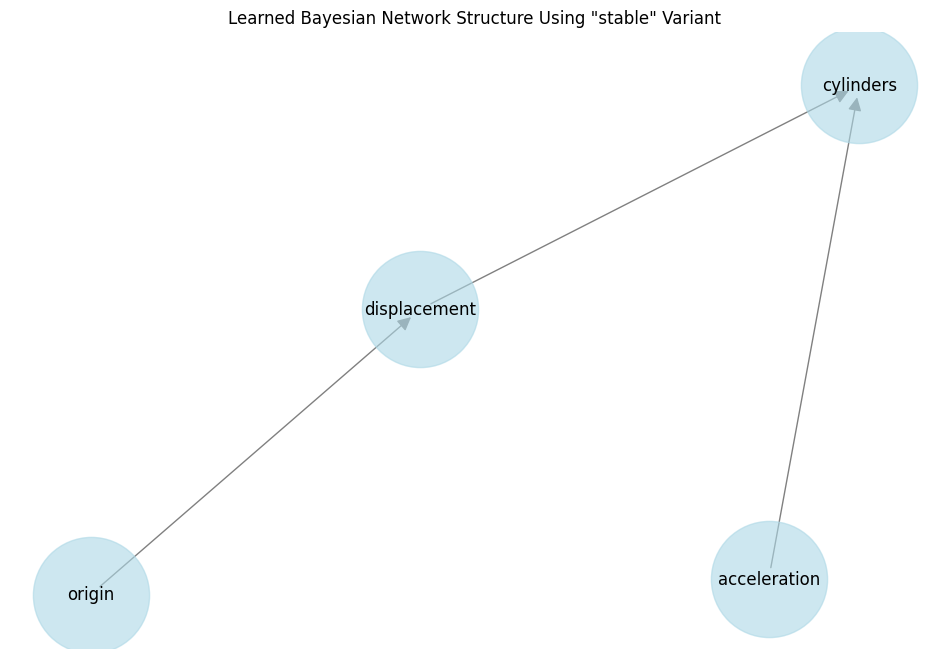

  0%|          | 0/4 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

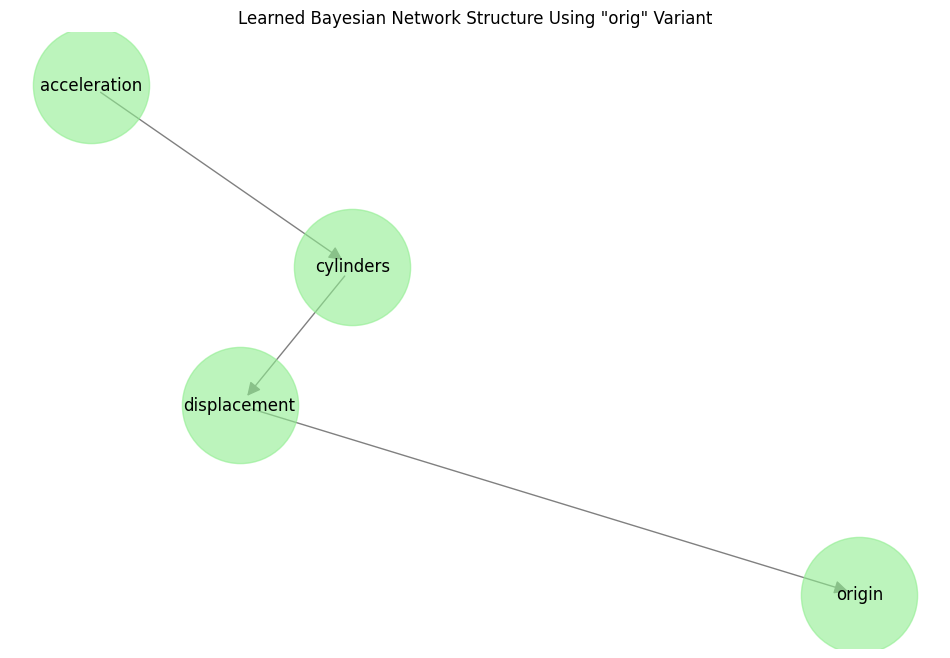

  0%|          | 0/4 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

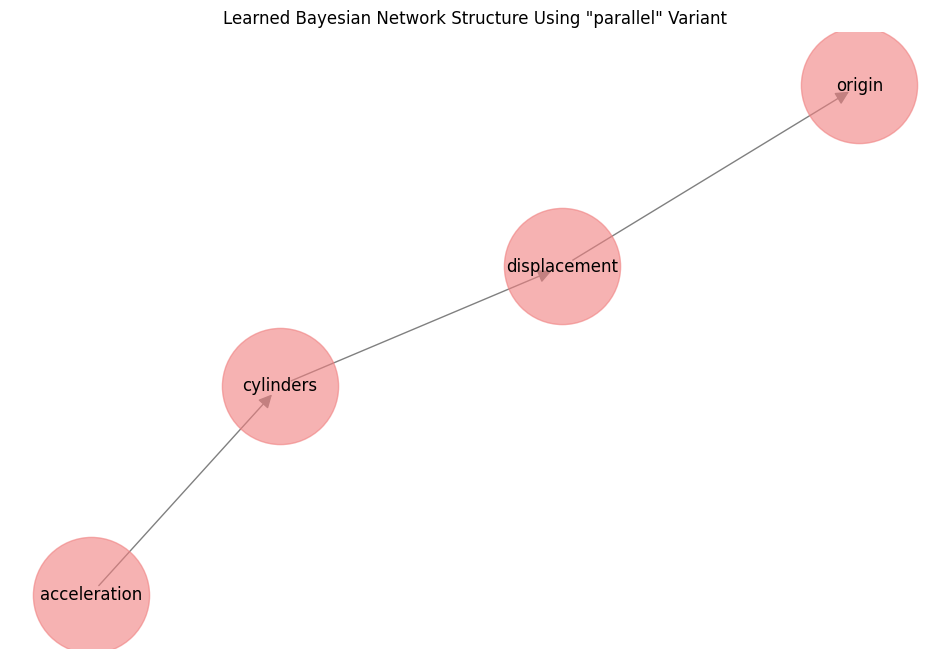

<Figure size 640x480 with 0 Axes>

In [19]:
import pandas as pd
import networkx as nx
from pgmpy.estimators import PC
from pgmpy.models import BayesianNetwork
import matplotlib.pyplot as plt

# Variants of the PC algorithm to be tested
variants = ['stable', 'orig', 'parallel']

for variant in variants:
    est = PC(data=df)
    estimated_model = est.estimate(variant=variant, max_cond_vars=4, return_type='dag', ci_test='chi_square')

    model = BayesianNetwork(estimated_model.edges())

    G = nx.DiGraph()
    G.add_edges_from(model.edges())

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=7000, node_color='lightblue' if variant == 'stable' else 'lightgreen' if variant == 'orig' else 'lightcoral', alpha=0.6)
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrowstyle='-|>', arrowsize=20, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')
    plt.title(f'Learned Bayesian Network Structure Using "{variant}" Variant')
    plt.axis('off')

    plt.savefig(f'bayesian_network_{variant}.png')  
    plt.show()

    plt.clf()

## 2b Hill Climb Search for Structure Learning
`pgmpy`'s `HillClimbSearch`: Aims to optimize a given score, starting from an initial model and iteratively refining it. The specific parameters of interest are:

### 1. **BICScore (Bayesian Information Criterion)**
   - Evaluates model fit penalized for the number of parameters to avoid overfitting, suitable for large datasets.

### 2. **K2Score**
   - Assesses model fit using a score based on Bayesian Dirichlet priors with pseudo-counts set to 1.

### 3. **BDsScore**
   - Adjusts Dirichlet parameters based on observed parent configurations, enhancing model relevance.


In [20]:
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BDeuScore

# Define the scoring methods
scoring_methods = {
    'BIC': BicScore(df),
    'BDeu': BDeuScore(df),
    'K2': K2Score(df)
}

# Initialize dictionary to store the models
models = {}

# Perform structure learning using Hill Climb Search with different scoring methods
for score_name, scoring_method in scoring_methods.items():
    estimator = HillClimbSearch(data=df)
    estimated_dag = estimator.estimate(scoring_method=scoring_method, max_indegree=4, max_iter=int(1e4))
    
    # Store each model in the dictionary with a unique name
    models[f'model_{score_name}'] = BayesianNetwork(estimated_dag.edges())
    
    # Print the learned structure
    print(f"Learned structure using {score_name} score:")
    print(models[f'model_{score_name}'].edges())

  0%|          | 0/10000 [00:00<?, ?it/s]

Learned structure using BIC score:
[('mpg', 'horsepower'), ('horsepower', 'acceleration'), ('cylinders', 'displacement'), ('cylinders', 'mpg'), ('cylinders', 'weight'), ('displacement', 'origin'), ('displacement', 'model year')]


  0%|          | 0/10000 [00:00<?, ?it/s]

Learned structure using BDeu score:
[('mpg', 'weight'), ('mpg', 'model year'), ('weight', 'origin'), ('cylinders', 'mpg'), ('cylinders', 'weight'), ('cylinders', 'horsepower'), ('cylinders', 'origin'), ('cylinders', 'acceleration'), ('cylinders', 'model year'), ('horsepower', 'mpg'), ('horsepower', 'acceleration'), ('horsepower', 'weight'), ('displacement', 'cylinders'), ('displacement', 'horsepower'), ('displacement', 'weight'), ('displacement', 'origin'), ('displacement', 'mpg'), ('car name', 'displacement')]


  0%|          | 0/10000 [00:00<?, ?it/s]

Learned structure using K2 score:
[('mpg', 'horsepower'), ('horsepower', 'acceleration'), ('cylinders', 'displacement'), ('cylinders', 'mpg'), ('cylinders', 'weight'), ('cylinders', 'horsepower'), ('cylinders', 'car name'), ('cylinders', 'acceleration'), ('cylinders', 'model year'), ('displacement', 'origin'), ('displacement', 'car name'), ('displacement', 'model year'), ('displacement', 'mpg'), ('weight', 'model year'), ('weight', 'mpg'), ('model year', 'car name'), ('origin', 'car name'), ('origin', 'model year')]


## 3a Maximum Likelihood Estimation (MLE) Parameter Estimation

This section of the notebook uses the `MaximumLikelihoodEstimator` from `pgmpy` to perform parameter estimation for a Bayesian Network model obtained using the BIC score:

- **Initialization**: An instance of `MaximumLikelihoodEstimator` is created with the Bayesian Network (`bic_model`) and the dataset (`df`).
- **Parameter Estimation**: The estimator computes the Conditional Probability Distributions (CPDs) for all nodes in the model.
- **Local Independencies**: The code also prints the local independencies of the network, which reveal conditional independencies among variables based on the structure of the Bayesian Network.


In [22]:
from pgmpy.estimators import MaximumLikelihoodEstimator

bic_model = models['model_BIC']

mle_estimator = MaximumLikelihoodEstimator(model=bic_model, data=df)

# Estimating the parameters for all nodes in the model
estimated_parameters = mle_estimator.get_parameters()

# Print the estimated CPDs
print("Estimated Conditional Probability Distributions (CPDs):")
for cpd in estimated_parameters:
    print(cpd)

# Print the local independencies of the network
print("\nLocal Independencies in the Bayesian Network:")
# Convert NodeView to a list before passing it to the local_independencies method
local_independencies = bic_model.local_independencies(list(bic_model.nodes()))
print(local_independencies)

Estimated Conditional Probability Distributions (CPDs):
+-----------+--------------+-----+--------------+--------------+
| cylinders | cylinders(3) | ... | cylinders(6) | cylinders(8) |
+-----------+--------------+-----+--------------+--------------+
| mpg(high) | 0.0          | ... | 0.25         | 0.0          |
+-----------+--------------+-----+--------------+--------------+
| mpg(low)  | 1.0          | ... | 0.75         | 1.0          |
+-----------+--------------+-----+--------------+--------------+
+------------------+---------------------+----------+
| mpg              | mpg(high)           | mpg(low) |
+------------------+---------------------+----------+
| horsepower(high) | 0.02040816326530612 | 0.9      |
+------------------+---------------------+----------+
| horsepower(low)  | 0.9795918367346939  | 0.1      |
+------------------+---------------------+----------+
+--------------+----------+
| cylinders(3) | 0.010101 |
+--------------+----------+
| cylinders(4) | 0.484848 |

## 3b. Parameter Estimation Using Expectation Maximization (EM)

This section uses the Bayesian Network model obtained via the BIC scoring method to estimate parameters using the Expectation Maximization algorithm.

In [23]:
from pgmpy.estimators import ExpectationMaximization as EM

bic_model = models['model_BIC']

em_estimator = EM(model=bic_model, data=df)

estimated_parameters = em_estimator.get_parameters()

print("Estimated Conditional Probability Distributions (CPDs) using EM:")
for cpd in estimated_parameters:
    print(cpd)

print("\nLocal Independencies in the Bayesian Network:")
local_independencies = bic_model.local_independencies(list(bic_model.nodes()))
print(local_independencies)

  0%|          | 0/100 [00:00<?, ?it/s]

Estimated Conditional Probability Distributions (CPDs) using EM:
+--------------------+--------------+-----+--------------+
| cylinders          | cylinders(3) | ... | cylinders(8) |
+--------------------+--------------+-----+--------------+
| displacement(high) | 0.0          | ... | 1.0          |
+--------------------+--------------+-----+--------------+
| displacement(low)  | 1.0          | ... | 0.0          |
+--------------------+--------------+-----+--------------+
+--------------------+---------------------+---------------------+
| horsepower         | horsepower(high)    | horsepower(low)     |
+--------------------+---------------------+---------------------+
| acceleration(high) | 0.15217391304347827 | 0.7547169811320755  |
+--------------------+---------------------+---------------------+
| acceleration(low)  | 0.8478260869565217  | 0.24528301886792453 |
+--------------------+---------------------+---------------------+
+-----------+--------------+-----+--------------+----